#Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations
## Authors: M. Raissi, P. Perdikaris, G.E. Karniadakis
## Team: Abby Schmid, Thomas Allard, Yang Xu

Imports and installs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thomas-allard/APPM5720/blob/master/NavierStokeExample.ipynb)


In [2]:
#!pip install sciann &> /dev/null
#!pip install matplotlib &> /dev/null
#!pip install scipy &> /dev/null
#!/usr/bin/env python3


## exact value of the parameters: lambda1 = 1.0, lambda2 = 0.01
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt
import scipy.io
import netCDF4
import xarray as xr

import os
# sns.set_theme()

In [3]:
# Specify parameters and things
mode = 'train'   # 'test' to load PINN weights from previously trained model
                # 'train' to train a new model

trained_file = 'trained-navier-stokes.hdf5'
#data_file = 'cylinder_nektar_wake.mat'
data_file = '../abaqus/final_elastic/elastic_cdf.nc'

In [4]:
data = netCDF4.Dataset(data_file)

In [5]:
# do stuff with time
# make a new array for time
time = []
nc = data
print("Appending times to an np array")
for ii in range(len(nc.variables)-2):
    if ii < 10:
        #print(nc.variables['step_00' + str(ii)].time)
        time.append(nc.variables['step_00' + str(ii)].time)
    elif ii >= 10 and ii < 100:
        #print(nc.variables['step_0' + str(ii)].time)
        time.append(nc.variables['step_0' + str(ii)].time)
    else:
        #print(nc.variables['step_' + str(ii)].time)
        time.append(nc.variables['step_' + str(ii)].time)
time = np.asarray(time)
print("Time:", time)
print("Shape of array:", np.shape(time))

Appending times to an np array
Time: [0.         0.01       0.02       0.03       0.04       0.05
 0.06       0.07       0.08       0.09       0.1        0.11
 0.12       0.13       0.14       0.15000001 0.16       0.17
 0.18000001 0.19       0.2        0.20999999 0.22       0.23
 0.23999999 0.25       0.25999999 0.27000001 0.28       0.28999999
 0.30000001 0.31       0.31999999 0.33000001 0.34       0.34999999
 0.36000001 0.37       0.38       0.38999999 0.40000001 0.41
 0.41999999 0.43000001 0.44       0.44999999 0.46000001 0.47
 0.47999999 0.49000001 0.5        0.50999999 0.51999998 0.52999997
 0.54000002 0.55000001 0.56       0.56999999 0.57999998 0.58999997
 0.60000002 0.61000001 0.62       0.63       0.63999999 0.64999998
 0.66000003 0.67000002 0.68000001 0.69       0.69999999 0.70999998
 0.72000003 0.73000002 0.74000001 0.75       0.75999999 0.76999998
 0.77999997 0.79000002 0.80000001]
Shape of array: (81,)


In [7]:
data.dimensions['field'='ux']

SyntaxError: invalid syntax (2686997596.py, line 1)

In [8]:
set = xr.open_dataset(data_file)

In [9]:
thing1=set.sel(field='ux').to_array()
thing2=set.sel(field='uy').to_array()
thing=np.dstack([thing1,thing2])

In [26]:
print(np.shape(thing)) # 81 displacements for 2760 node grid
print(np.shape(thing[:,0,0]))
thing
ux_node_1 = thing[:,0,1]

(81, 2760, 2)
(81,)


In [23]:
import matplotlib.pyplot as plt

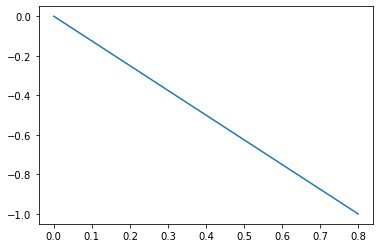

In [27]:
plt.plot(time,ux_node_1)
plt.show()

In [11]:
#times=set.sel(attr='time')
times = set.attrs
print(times)

{}


In [3]:
# define function for subsampling data
def PrepareData(num_data, data_file, random=True):
    
    # Load data
    #data = scipy.io.loadmat('/content/' + data_file)
    #data = scipy.io.loadmat(data_file)
    data = netCDF.Dataset(data_file)
    
    # will want to change these to correspond to our input variables
    U_star = data['U_star'] # N x 2 x T
    P_star = data['p_star'] # N x T
    t_star = data['t'] # T x 1
    X_star = data['X_star'] # N x 2
    
    N = X_star.shape[0]
    T = t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T
    TT = np.tile(t_star, (1,N)).T # N x T
    
    UU = U_star[:,0,:] # N x T
    VV = U_star[:,1,:] # N x T
    PP = P_star # N x T
    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, num_data, replace=False)
    else:
        idx = np.arange(0, N*T)
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
 
    return (x,y,t,u,v,p)


In [4]:
# Setting up cost function
layers = 8
neurons = 20

x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

P = sn.Functional("P", [x, y, t], layers*[neurons], 'tanh')
Psi = sn.Functional("Psi", [x, y, t], layers*[neurons], 'tanh')

lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")
## true value lamdba1 = 

# from continuity equation for incompressible fluids, what do we want to use?
u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)

p_x = sn.diff(P, x)
p_y = sn.diff(P, y)

# Define constraints 
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(P)

c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy)) # f in paper
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy)) # g in paper
c3 = sn.Data(u_x + v_y) # # continuity equation for incompressible fluids

c4 = Psi*0.0 # not sure about this one

if mode == 'train':
    x_train, y_train, t_train, u_train, v_train, p_train = PrepareData(5000, data_file, random=True)
# Define the optimization model (set of inputs and constraints)
    model = sn.SciModel(
        inputs=[x, y, t],
        targets=[d1, d2, d3, c1, c2, c3, c4],
        loss_func="mse",
        plot_to_file='NS-Model.png'
    )

    input_data = [x_train, y_train, t_train]

    # like an initial condition for c1, c2, c3, and c4
    data_d1 = u_train
    data_d2 = v_train
    data_d3 = p_train
    data_c1 = 'zeros'
    data_c2 = 'zeros'
    data_c3 = 'zeros'
    data_c4 = 'zeros'
    target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

    ## hyper parameter define

    Epochs= 10000
    Batch_size=100
    Learning_rate=0.001
    Reduce_lr_after=1000

    #log the data

    log_directory = f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
        print(f'{log_directory} is created!')

    ##train PINN

    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs= Epochs,
        batch_size= Batch_size,
        shuffle=True,
        learning_rate= Learning_rate,
        reduce_lr_after= Reduce_lr_after,
        stop_loss_value=1e-8,
        verbose=1,
        log_parameters={'parameters':[lambda1,lambda2],
                        'freq':1}
    )

    ## logs and plots
    model.save_weights('trained-navier-stokes.hdf5')
    ## print iterated parameters value
    print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))
    with open(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/parameters_{layers}_{neurons}.txt', 'w') as f:
        f.write(f"lambda1: {lambda1.value},  lambda2: {lambda2.value}")
    print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))

    ## print loss function value
    print("loss: {}".format(history.history['loss']))
    with open(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/loss_{layers}_{neurons}.txt', 'w') as f:
        f.write(f"loss: {history.history['loss']}")
    ## plot loss function
    plt.figure(f'Train_Loss_{layers}_{neurons}')
    plt.semilogy(history.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.savefig(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/loss_{layers}_{neurons}.png')
    plt.semilogy(history.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [5]:
if mode == 'test':
    x_test, y_test, t_test, u_test, test, p_test = PrepareData(5000, data_file, random=True)
    # test_input_data = [x_test, y_test, t_test]
    
    # Load data
    data = scipy.io.loadmat(data_file)

    # define model
    model = sn.SciModel(
        inputs=[x, y, t],
        targets=[d1, d2, d3, c1, c2, c3, c4],
        loss_func="mse",
        load_weights_from= trained_file
    )

    
    snap = np.array([100]) # not sure I understand why this snapshot works
    U_star = data['U_star'] # N x 2 x T
    P_star = data['p_star'] # N x T
    t_star = data['t'] # T x 1
    X_star = data['X_star'] # N x 2

    x_star = X_star[:,0:1]
    y_star = X_star[:,1:2]
    p_star = P_star[:,snap]

    N = X_star.shape[0]
    T = t_star.shape[0]
    TT = np.tile(t_star,(1,N)).T
    t_star = TT[:,snap]
    t = TT.flatten()[:,None] # NT x 1

    test_input_data = [x_star, y_star, t_star]

    test_result = model.predict(test_input_data)

    print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))



2022-04-19 16:01:09.155860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-19 16:01:09.155923: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-19 16:01:09.155991: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-04-19 16:01:09.156375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 16:01:09.443947: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2208000000 Hz


lambda1: [0.99794099],  lambda2: [0.0108588]


In [6]:
#Arrange data for plotting

# Load data
data = scipy.io.loadmat(data_file)
p_pred = test_result[2]
# Unpacking the .mat file 
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
p_star = P_star[:,snap]
#p_test = P_pred[:,snap]
# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)

from scipy.interpolate import griddata
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')


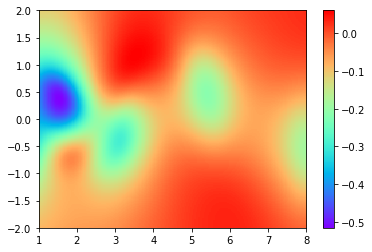

In [7]:
# Plot predicted pressure field
plt.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
plt.colorbar()

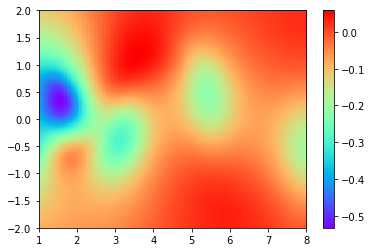

In [8]:
# Plot "exact" pressure field
plt.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
plt.colorbar()

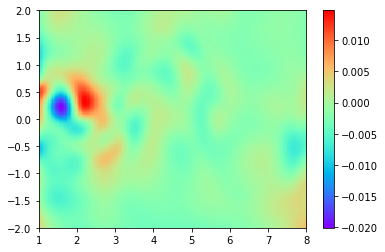

In [9]:
# plot difference between prediction and "exact" solution
diff = P_exact - PP_star
plt.imshow(diff, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
plt.colorbar()